In [1]:
from collections import defaultdict, Counter
from datetime import datetime
from xml.etree import ElementTree as ET
import seaborn as sns
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer, util
from tqdm.notebook import trange, tqdm
from sklearn.metrics import pairwise_distances, log_loss
import ot
import numpy as np
from itertools import combinations
import random
import pandas as pd
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler
from copy import deepcopy
import pickle
from scipy.special import expit, logit
import torch
from torch import nn
from sklearn.isotonic import IsotonicRegression
import csv, os, re
from sklearn.decomposition import PCA
from sklearn.neighbors import KernelDensity
from scipy.special import logsumexp
import math
from itertools import product
import cvxpy as cp
import gurobipy as gp

In [2]:
small_pred_scores = np.load("tmp_dset/small_pred_scores.npy")
alloc_max_usw = np.load("tmp_dset/alloc_max_usw.npy")
dr_all = np.load("tmp_dset/dr_all.npy")
dr_all = dr_all.reshape(small_pred_scores.shape)**(-1)
eta = 0.05
xe_test = 0.05

In [3]:
m = gp.Model()

beta = m.addMVar(small_pred_scores.shape, lb=0, name='beta')
lam = m.addVar(lb=0, name='lam')
aux = m.addMVar(small_pred_scores.shape, name='aux')

alloc = alloc_max_usw

x = np.log(1-small_pred_scores)
y = np.log(small_pred_scores)
dr_mat = dr_all.reshape(small_pred_scores.shape)

dr_times_x_minus_y = dr_mat * (x - y)
dr_times_x = dr_mat * x

obj = -1*lam*(xe_test + eta)
obj -= aux.sum()
obj -= beta.sum()
obj += 5*alloc.sum()

m.setObjective(obj, gp.GRB.MAXIMIZE)

num_users, num_questions = small_pred_scores.shape[0], small_pred_scores.shape[1]

one_over_mn = (1/small_pred_scores.size)
m.addConstrs(beta[i,j] + one_over_mn*lam*dr_times_x_minus_y[i,j] + 6*alloc[i,j] >= 0 for (i,j) in product(range(num_users), range(num_questions)))

m.addConstrs(aux[i,j] == one_over_mn*lam*dr_times_x[i,j] for (i,j) in product(range(num_users), range(num_questions)))

m.optimize()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-09
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 6160 rows, 6161 columns and 12320 nonzeros
Model fingerprint: 0xfffdc5d9
Coefficient statistics:
  Matrix range     [5e-04, 1e+00]
  Objective range  [1e-01, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+00, 6e+00]
Presolve removed 6160 rows and 6161 columns
Presolve time: 0.02s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.4000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.03 seconds (0.00 work units)
Optimal objective  1.400000000e+03


In [4]:
obj.getValue()

array(1400.)

In [5]:
def get_worst_case(alloc, preds_score, dens_ratio, emp_loss, eta):
    m = gp.Model()

    v = m.addMVar(preds_score.shape)
    aux = m.addMVar(preds_score.shape)

    x = np.log(1-preds_score )
    y = np.log(preds_score )

    dr_times_x_minus_y = dens_ratio * (x - y)
    dr_times_x = dens_ratio * x

    rhs = preds_score.size*(emp_loss + eta)
    lhs = aux.sum()
    
    num_users, num_questions = small_pred_scores.shape[0], small_pred_scores.shape[1]

    m.addConstrs(aux[i,j] == v[i,j]*dr_times_x_minus_y[i,j] - dr_times_x[i,j] for (i,j) in product(range(num_users), range(num_questions)))
    m.addConstr(lhs <= rhs)
    m.addConstr(v >= 0)
    m.addConstr(v <= 1)
    obj = (alloc*(6*v-5)).sum()
    m.setObjective(obj)
    m.optimize()

    return v.X

In [6]:
worst_v = get_worst_case(alloc, small_pred_scores, 
                         dr_all.reshape(small_pred_scores.shape), 
                         xe_test, eta)

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 9241 rows, 6160 columns and 15400 nonzeros
Model fingerprint: 0x7d4479aa
Coefficient statistics:
  Matrix range     [1e+00, 5e+00]
  Objective range  [6e+00, 6e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+02]
Presolve removed 9240 rows and 5880 columns
Presolve time: 0.01s
Presolved: 1 rows, 280 columns, 280 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.4000000e+03   1.011007e+02   0.000000e+00      0s
       1   -1.0001968e+02   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.03 seconds (0.01 work units)
Optimal objective -1.000196753e+02


In [7]:
np.sum((worst_v*6 - 5)*alloc)

-100.01967528286792

<Axes: ylabel='Count'>

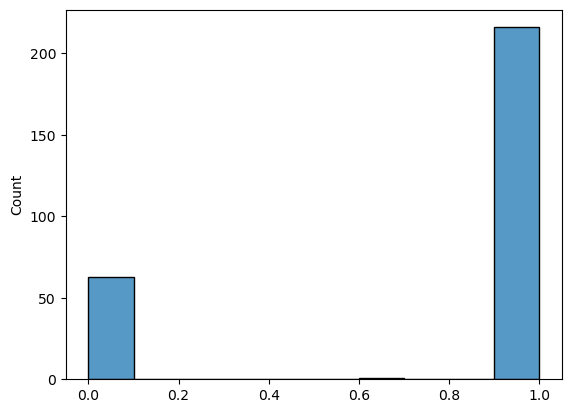

In [8]:
sns.histplot(worst_v[np.where(alloc)])

In [9]:
def compute_primal(A_prime, a_prime, b_prime, p_hat, Lamda, xi, eta):
    m = A_prime.shape[0]
    n = A_prime.shape[1]
    A_prime = A_prime.flatten() # Row major
    p_hat = p_hat.flatten()
    Lamda = Lamda.flatten()
    A_temp = A_prime * (a_prime- b_prime)

    eps=0
    log_p_phat = np.log(p_hat + eps)
    log_one_minus_phat = np.log(1-p_hat + eps)

    model = gp.Model()

    mn = int(m*n)
    norm = 1.0/mn


    p = model.addMVar(mn, lb=0, ub=1.0, vtype=gp.GRB.CONTINUOUS, name="pval")

    model.addConstr(gp.quicksum(norm*(-log_p_phat[idx]*Lamda[idx]*p[idx] - Lamda[idx] * (1-p[idx])*log_one_minus_phat[idx]) for idx in range(mn)) == eta + xi)

    model.setObjective((A_temp)@ p, gp.GRB.MINIMIZE)
    model.setParam('OutputFlag', 1)

    model.optimize()
    pvals = p.X

    return list(pvals)


def compute_dual(A_prime, a_prime, b_prime, p_hat, Lamda, xi, eta):
    m = A_prime.shape[0]
    n = A_prime.shape[1]
    A_prime = A_prime.flatten()
    p_hat = p_hat.flatten()
    Lamda = Lamda.flatten()
    A_temp = A_prime * (a_prime - b_prime)

    eps=0
    log_p_phat = np.log(p_hat ).flatten()
    log_one_minus_phat = np.log(1-p_hat ).flatten()

    mn = int(m*n)
    norm = 1.0/mn
    model = gp.Model()


    e = -1.0*(mn*(xi + eta)  + np.sum(Lamda *log_one_minus_phat))
    neg_ones = -1*np.ones(mn)
    c= np.vstack((np.array([e]).reshape(1,1),neg_ones.flatten().reshape(-1,1))).flatten()
    f =  Lamda* (log_p_phat - log_one_minus_phat)

    x = model.addMVar(mn+1, lb=0, ub=gp.GRB.INFINITY, vtype=gp.GRB.CONTINUOUS, name="pval")

    for jdx in range(mn):
        model.addConstr(f[jdx]*x[0] - x[jdx+1] <= A_temp[jdx],name='ctr'+ str(jdx))

    model.setObjective(c@x, gp.GRB.MAXIMIZE)
    model.setParam('OutputFlag', 1)

    model.optimize()
    pvals = x.X

    return list(pvals)

In [10]:
eta = 0.05
xe_test = 0.05
a_prime=1
b_prime=-5
p_primal =compute_primal(alloc_max_usw,a_prime , b_prime, small_pred_scores, dr_all,xe_test, eta)
p_primal = np.array(p_primal)
p_dual = compute_dual(alloc_max_usw,a_prime , b_prime, small_pred_scores, dr_all,xe_test, eta)
p_dual = np.array(p_dual)

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1 rows, 3080 columns and 3080 nonzeros
Model fingerprint: 0x34b5dc90
Coefficient statistics:
  Matrix range     [5e-04, 2e-03]
  Objective range  [6e+00, 6e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e+00, 3e+00]
Presolve removed 0 rows and 2800 columns
Presolve time: 0.01s
Presolved: 1 rows, 280 columns, 280 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.201588e+00   0.000000e+00      0s
       1    1.2999803e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.299980325e+03
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|

In [11]:
# a_prime, b_prime = 1, -5
# p_primal = compute_primal(alloc_max_usw,a_prime , b_prime, small_pred_scores, dr_all,xe_test, eta)

In [12]:
# p_dual = compute_dual(alloc_max_usw,a_prime , b_prime, small_pred_scores, dr_all,xe_test, eta)

<Axes: ylabel='Count'>

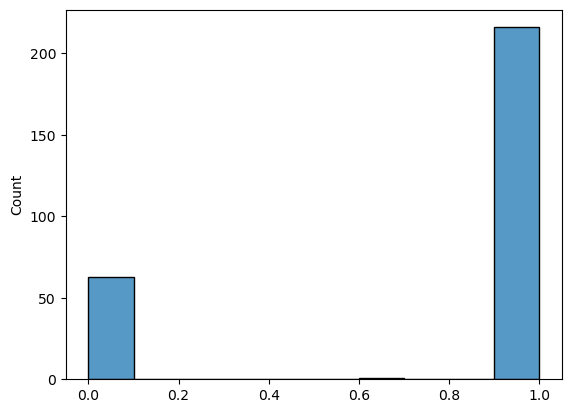

In [13]:
sns.histplot(worst_v[np.where(alloc)])

<Axes: ylabel='Count'>

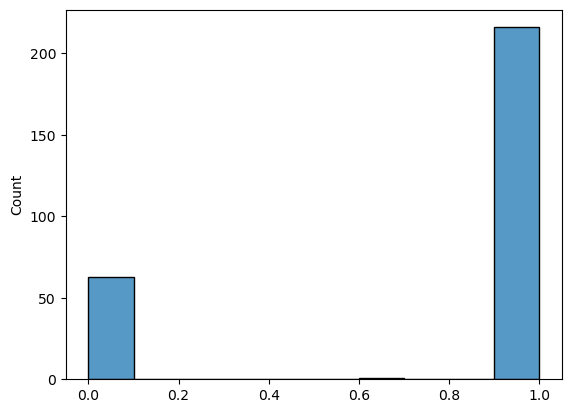

In [14]:
sns.histplot(p_primal.reshape(alloc.shape)[np.where(alloc)])

In [15]:
np.sum(worst_v.reshape(alloc.shape) - p_primal.reshape(alloc.shape))

1.2650436254091346e-11

In [16]:
print("Elita's primal vs. my primal:")
print(np.sum(alloc_max_usw*((a_prime-b_prime)*np.array(p_primal).reshape(small_pred_scores.shape) + b_prime)), np.sum((worst_v*6 - 5)*alloc))

Elita's primal vs. my primal:
-100.01967528294381 -100.01967528286792


In [17]:
print(np.sum(worst_v <= 0.99), np.sum(np.array(p_primal) <= 0.99))

64 64


In [18]:
# np.sum(alloc_max_usw*(a_prime*np.array(p_dual).reshape((small_pred_scores.shape)) + b_prime))

In [19]:
len(p_dual), len(p_primal)

(3081, 3080)

In [20]:
p_dual

array([1.85898889, 4.830766  , 4.81458922, ..., 6.00945668, 5.84207631,
       6.11478167])

In [21]:
p_primal

array([1., 1., 1., ..., 1., 1., 1.])

In [22]:
xi = .05
e = -1.0*(dr_all.size*(xi + eta)  + np.sum(dr_all * np.log(1-small_pred_scores)))
neg_ones = -1*np.ones(dr_all.size)
c= np.vstack((np.array([e]).reshape(1,1),neg_ones.flatten().reshape(-1,1))).flatten()
print(np.matmul(c.T, p_dual) - 5*np.sum(alloc_max_usw))

-100.0196752828615


# Now here's the code for the GESW